In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools as it
from sklearn.preprocessing import StandardScaler, normalize
import warnings

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor, GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb


In [2]:
train = pd.read_csv('data/train.csv')
train.shape

(5380, 767)

In [3]:
test = pd.read_csv('data/test.csv')
test.shape

(4403, 766)

## Missing Vals

In [4]:
num_missing = train.isna().sum().sum()
print(num_missing)

num_cols_missing = (train.isna().any()).sum()
print(num_cols_missing)

num_rows_missing = (train.isna().any(axis=1)).sum()
print(num_rows_missing)

29911
473
2523


In [5]:
y_train = train['y']
X_train = train.drop(['y', 'id'], axis = 1)

In [6]:
col_id = test['id']
X_test = test.drop(['id'], axis = 1)

In [7]:
#KNN Imputation
imputer = KNNImputer(n_neighbors = 5)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns = X_test.columns)

## Feature Selection

In [8]:
#Drop column of 0/1
X_train = X_train.drop(['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703'], axis = 1)
X_test = X_test.drop(['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703'], axis = 1)
print(X_train.shape)

(5380, 754)


In [9]:
#Drop col with low var
var = X_train.var()
low_var_col = var[var < 0.01].index.tolist()
X_train.drop(low_var_col, axis=1, inplace=True)
X_test.drop(low_var_col, axis=1, inplace=True)
print(X_train.shape)

(5380, 707)


In [10]:
#Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
pca = PCA()
pca.fit(X_train)

eigenvalues = pca.explained_variance_
variance_proportion = eigenvalues / np.sum(eigenvalues)

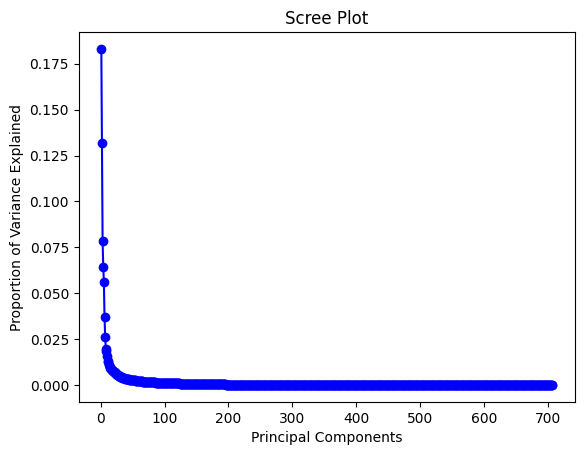

The optimal number of PCs to retain is 75


In [52]:
plt.plot(range(1, len(variance_proportion)+1), variance_proportion, 'bo-')
plt.xlabel('Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot')
plt.show()

# Identify the elbow point
cumulative_variance = np.cumsum(variance_proportion)
elbow_point = np.argmax(cumulative_variance >= 0.9) + 1
print("The optimal number of PCs to retain is", elbow_point)

In [11]:
pca_75 = PCA(n_components=75)
pca_75.fit(X_train)

X_train = pd.DataFrame(pca_75.transform(X_train))
print(X_train.shape)

X_test = pd.DataFrame(pca_75.transform(X_test))
print(X_test.shape)

(5380, 75)
(4403, 75)


## Modeling

### XGBoost

>2 11.829 (0.768)
>3 11.294 (0.729)
>4 11.037 (0.701)
>5 10.892 (0.648)
>6 10.793 (0.608)
>7 10.742 (0.597)


Text(0.5, 0, 'Number of trees')

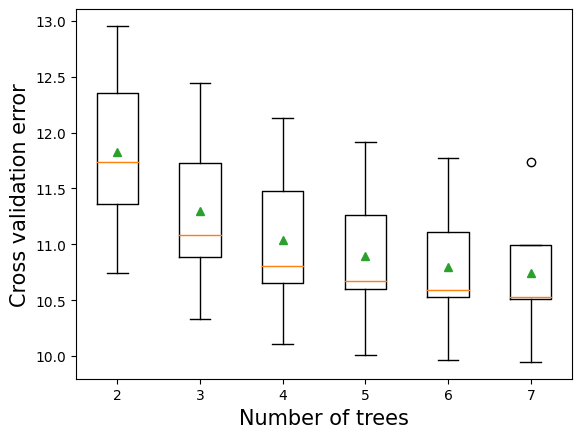

In [37]:
def get_models():
    models = dict()
    for n in range(2, 8):
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 10.299 (1.316)
>2 10.207 (1.388)
>3 10.372 (1.473)
>4 10.527 (1.303)
>5 10.666 (1.216)
>6 10.673 (1.141)


Text(0.5, 0, 'Depth of each tree')

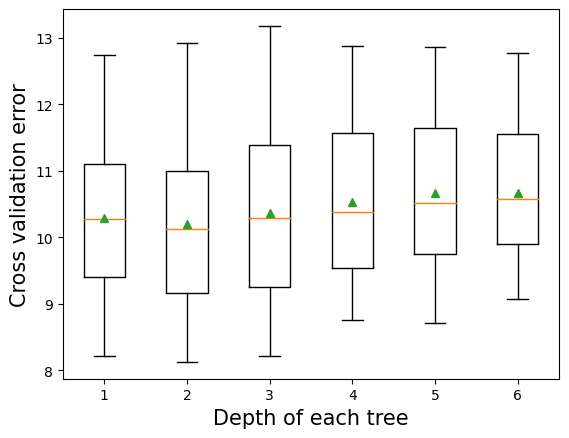

In [16]:
def get_models():
    models = dict()
    for i in range(1, 7):
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.0125 10.8 (1.6)
>0.0150 10.7 (1.6)
>0.0175 10.5 (1.5)
>0.0200 10.4 (1.5)


Text(0.5, 0, 'Learning rate')

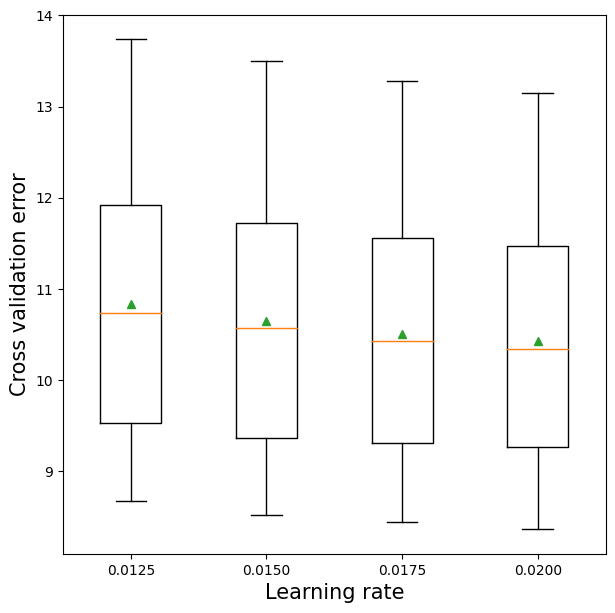

In [18]:
def get_models():
    models = dict()
    for i in [0.0125, 0.015, 0.0175, 0.0200]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
    
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

>0.0100 11.1 (1.2)
>0.0500 11.0 (1.2)
>0.1000 10.9 (1.1)
>0.2500 10.8 (1.1)
>0.5000 10.7 (1.2)
>1.0000 10.7 (1.1)


Text(0.5, 0, 'reg_lambda')

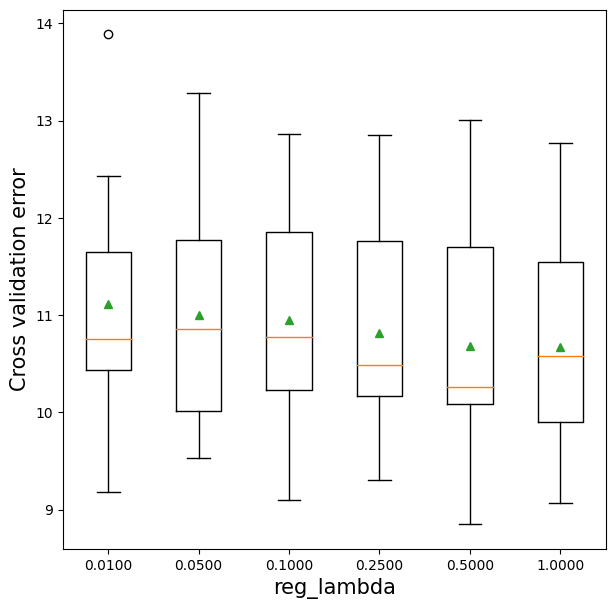

In [19]:
def get_models():
    models = dict()
    for i in [0.01, 0.05, 0.1, 0.25, 0.5, 1]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))

plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

In [20]:
param_grid = {'n_estimators':[3],
              'max_depth': [2],
              'learning_rate': [0.0150, 0.0175],
              'reg_lambda':[0.01, 0.05, 0.10]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,                             
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train , y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Optimal parameter values = {'learning_rate': 0.0175, 'max_depth': 2, 'n_estimators': 3, 'reg_lambda': 0.05}
Optimal cross validation R-squared =  -0.4033699201173963


In [12]:
model_XG = xgb.XGBRegressor(n_estimators=3, max_depth=2, learning_rate = 0.0175, reg_lambda=0.05,
                            random_state=1,).fit(X_train, y_train)

### AdaBoost

>3 11.714 (0.505)
>4 11.254 (0.424)
>5 11.482 (0.343)
>6 11.532 (0.564)
>7 11.614 (0.445)
>8 11.613 (0.496)
>9 11.899 (0.508)
>10 11.868 (0.480)
>11 12.111 (0.514)
>12 12.094 (0.439)
>13 12.314 (0.414)
>14 12.352 (0.262)


Text(0.5, 0, 'Number of trees')

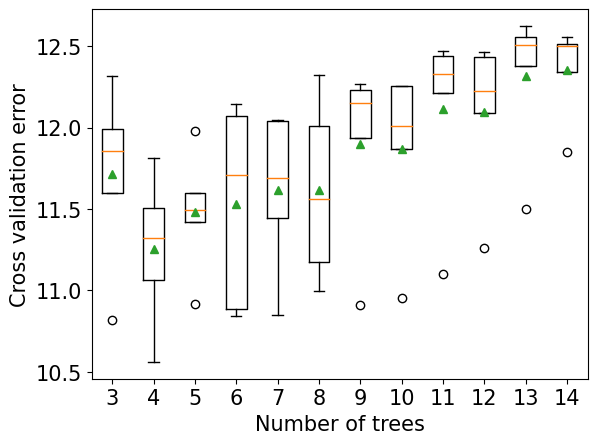

In [76]:
def get_models():
    models = dict()
    for n in range(3, 15):
        models[str(n)] = AdaBoostRegressor(n_estimators=n,random_state=1)
    return models

def evaluate_model(model, X_train, y_train):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 12.601 (1.084)
>2 14.320 (1.407)
>3 15.202 (0.671)
>4 13.358 (0.883)
>5 12.022 (1.014)
>6 11.136 (1.165)
>7 10.759 (1.330)
>8 10.547 (1.482)
>9 10.531 (1.425)
>10 10.449 (1.556)


Text(0.5, 0, 'Depth of each tree')

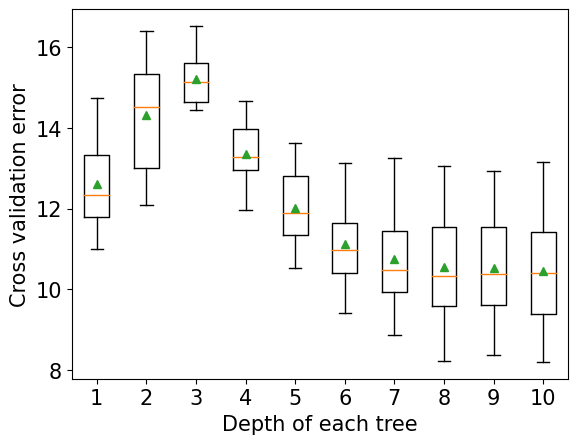

In [77]:
def get_models():
    models = dict()
    for i in range(1,11):
        base = DecisionTreeRegressor(max_depth=i)
        models[str(i)] = AdaBoostRegressor(base_estimator=base,n_estimators=50)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

In [78]:
model = AdaBoostRegressor(random_state=1)
grid = dict()
grid['n_estimators'] = [4]
grid['base_estimator'] = [DecisionTreeRegressor(max_depth=4), DecisionTreeRegressor(max_depth=5)]

cv = KFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: -127.814694 using {'base_estimator': DecisionTreeRegressor(max_depth=5), 'n_estimators': 4}


In [13]:
model_ADA = AdaBoostRegressor(n_estimators=4, base_estimator=DecisionTreeRegressor(max_depth=5), random_state=1).fit(X_train, y_train)

c:\Users\subwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


### RF

In [63]:
warnings.filterwarnings("ignore")

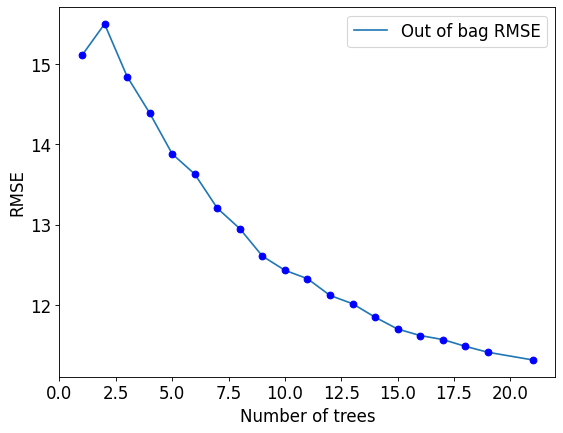

In [65]:
oob_rsquared = {}
test_rsquared = {}
oob_rmse = {}
test_rmse = {}

for i in np.linspace(1, 21, 20, dtype=int):
    model = RandomForestRegressor(n_estimators=i, random_state=1, max_features="sqrt",
                                   n_jobs=-1, oob_score=True).fit(X_train, y_train)
    oob_rsquared[i] = model.oob_score_
    oob_rmse[i] = np.sqrt(mean_squared_error(model.oob_prediction_, y_train))

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list(oob_rmse.keys()), list(oob_rmse.values()), label='Out of bag RMSE')
plt.plot(list(oob_rmse.keys()), list(oob_rmse.values()), 'o', color='blue')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()


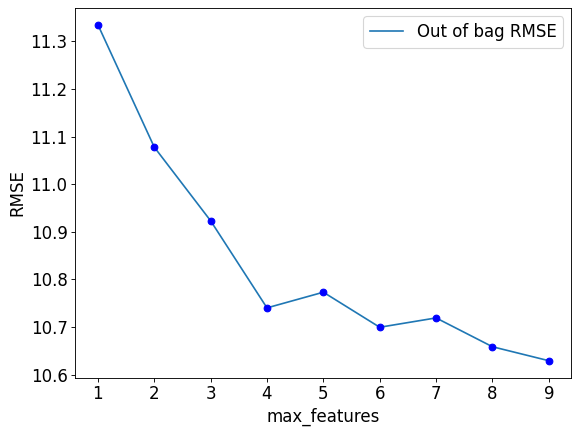

In [66]:
oob_rsquared = {}
test_rsquared = {}
oob_rmse = {}
test_rmse = {}

for i in range(1, 10):
    model = RandomForestRegressor(n_estimators=100, random_state=1, max_features=i,
                                   n_jobs=-1, oob_score=True).fit(X_train, y_train)
    oob_rsquared[i] = model.oob_score_
    oob_rmse[i] = np.sqrt(mean_squared_error(model.oob_prediction_, y_train))

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list(oob_rmse.keys()), list(oob_rmse.values()), label='Out of bag RMSE')
plt.plot(list(oob_rmse.keys()), list(oob_rmse.values()), 'o', color='blue')
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.legend()


In [67]:
params = {'n_estimators': [2, 3, 4, 5],
          'max_features': [2, 3, 4]}
param_list=list(it.product(*(params[Name] for Name in params)))
oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestRegressor(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_features=pr[1],n_jobs=-1).fit(X_train, y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

Best params =  (5, 3)
Best score (R-squared) =  -0.3859271378017928


In [14]:
model_RF = RandomForestRegressor(n_estimators=5, max_features=3, random_state=1, n_jobs=-1).fit(X_train, y_train)

### SVM

In [15]:
SVM = SVR()

param_grid = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 
              'C': (0.01, 0.1, 1, 10), 
              'degree': (2, 3, 4),
              'gamma': (0.001, 0.01, 0.1, 1)}

grid_search = RandomizedSearchCV(SVM, param_grid, scoring = 'accuracy', random_state=1, verbose = 2, n_iter=5, n_jobs = -1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\subwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(estimator=SVR(), n_iter=5, n_jobs=-1,
                   param_distributions={'C': (0.01, 0.1, 1, 10),
                                        'degree': (2, 3, 4),
                                        'gamma': (0.001, 0.01, 0.1, 1),
                                        'kernel': ('linear', 'poly', 'rbf',
                                                   'sigmoid')},
                   random_state=1, scoring='accuracy', verbose=2)

In [16]:
optimal_kernel = grid_search.best_estimator_.kernel
optimal_C = grid_search.best_estimator_.C
optimal_degree = grid_search.best_estimator_.degree
optimal_gamma = grid_search.best_estimator_.gamma

model_SVM =  SVR(kernel=optimal_kernel, C=optimal_C, degree=optimal_degree, gamma=optimal_gamma).fit(X_train, y_train)

### ElasticNet

In [17]:
model_ENET = ElasticNetCV(l1_ratio=0.5, alphas=[0.1, 0.5, 1.0])
model_ENET.fit(X_train, y_train)

ElasticNetCV(alphas=[0.1, 0.5, 1.0])

### Ensemble

In [18]:
model_ensemble= StackingRegressor(estimators = [('XG', model_XG),
                                                ('ADA', model_ADA),
                                                ('RF', model_RF),
                                                ('SVM', model_SVM),
                                                ('ENET', model_ENET)],
                      final_estimator = LassoCV(),
                      cv = KFold(n_splits = 5, shuffle = True, random_state=1))
model_ensemble.fit(X_train, y_train)

c:\Users\subwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\subwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\subwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\subwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\subwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: Futu

StackingRegressor(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                  estimators=[('XG',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_ty...
                                            predictor=None, random_state=1, ...)),
                              ('ADA',
                               AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                                                 n_estimators=4,
                                                 random_state=1)),
                              ('RF',
                               RandomForestRegressor(max_features=3,
                                                     n_estimators=5, n_jobs=-1,
                                                     random_state=1)),
                              ('SVM',
                               SVR(C=0.01, degree=4, gamma=1, kernel='linear')),
                              ('ENET', ElasticNetCV(alphas=[0.1, 0.5, 1.0]))],
                  final_estimator=LassoCV())

In [115]:
model_ensemble.final_estimator_.coef_

array([1.58754109, 0.18503703, 0.11609878, 0.33063698, 0.62972564])

## Prediction

In [107]:
pred = model_ensemble.predict(X_test)

pred_v21 = pd.DataFrame(index=range(X_test.shape[0]), columns=range(2))
pred_v21.columns = ['id', 'y']
pred_v21['id'] = col_id
pred_v21['y'] = pred
pred_v21

,id,y
0,5380,5.255194
1,5381,13.875789
2,5382,3.290660
3,5383,4.547483
4,5384,6.307909
...,...,...
4398,9778,1.911735
4399,9779,9.600179
4400,9780,9.176266
4401,9781,10.754028


In [108]:
pred_v21.to_csv('pred_v21.csv', index=True)